### Importing of Libraries

In [1]:
# importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Data download
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

### Data Cleaning and EDA

In [3]:
#Checking for null values in the train and test datasets provided
print('Checking for null values in the four datasets:\n\nTRAIN DATA\n{}\n\nTEST DATA\n{}\n'.format(train.isnull().sum(),test.isnull().sum()))

Checking for null values in the four datasets:

TRAIN DATA
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

TEST DATA
Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64



In [4]:
# Now that there is no more null data in our datasets, lets proceed to look deeper into the datasets
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


 As a overview the following can be deduced from the .info() function of the dataframes:
 - The train set has 10506 records and test set has 116293 records thus indicating a heavily imbalanced dataset
 - WnvPresent is the target variable thus not found in the test set and Id is only in the test set as it is meant for Kaggle submission
 - As NumMosquitos is only found in the train set, it will be removed for the modelling processing but will still be used for the initial EDA
 - From a visual inspection it is observed that several columns are related to the location and thus may potentially have high correlation(Address, Street, AddressNumberAndStreet , Latitude , Longitude and AddressAccuracy)

C:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


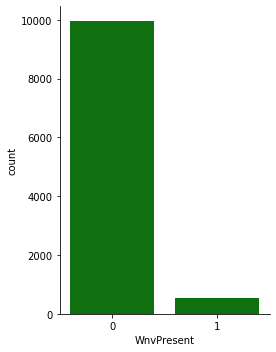

In [6]:
# The below histogram clearly depicts the imbalance in the predicted variable.
sns.factorplot("WnvPresent", data=train, aspect=0.75,
                       kind="count", color='green',)

This imbalance can be handled at the point of train-test split prior to modelling by stratifying the data. It will ensure the split will take into account the imbalance.

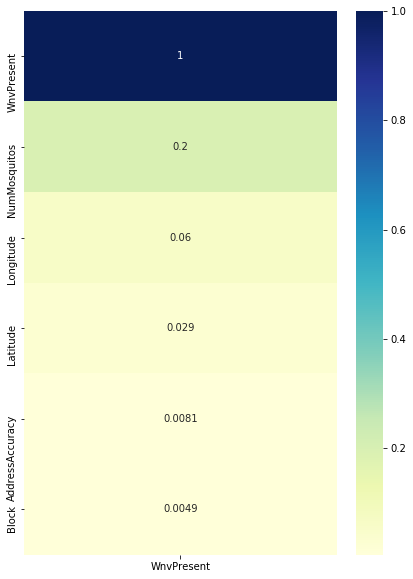

In [7]:
# An overview of datasets correlation with target variable,WnvPresent. 
fig = plt.figure(figsize=(7,10))
fig.set_title = ('Heatmap for Correlation of features with WnvPresent')
sns.heatmap(abs(train.corr())[['WnvPresent']].sort_values('WnvPresent', ascending = False),annot = True,cmap="YlGnBu")

- The NumMosquitos column has the highest correlation with the target variable which clearly indicates that a reduction in the number of mosquitoes will affect the presence of the virus.
- However the other variables in the heatmap which are related to location have an extremely low correlation(less than 0.06) with the target variable thus these can possibly be dropped from the dataset prior to modelling.

In [8]:
# Another consideration to eliminate the address related columns is because all the address data essentially point to the
# location of the traps as per kaggle description. The unique counts of the Trap and Address columns were counted and 
# the comparison aided in determining if there is any differences.
Trap_Series = pd.DataFrame(train.Trap.value_counts().sort_values(ascending = False))
Address_series = pd.DataFrame(train.Address.value_counts().sort_values(ascending = False))
(Address_series.Address - Trap_Series.Trap).notnull().sum()

0

 As the difference is 0 it is clear that all data that can be represented by Data can actually be represented by the Trap column. Therefore when we clean we can drop the columns related to address and also proceed to Dummify the trap column as numeric data will be the optimal for our classification based models. For the trap names, the names with an alphabet suffix are satellite traps and are additional traps in the same vicinity as the trap name without the suffix. Therefore prior to dummifying the column we shall also remove those suffixes under the assumption that the distance between these traps are negligible.

Merging the datasets for cleaning

In [9]:
train_test = pd.concat([train,test],axis = 0)

As the test data does not have NumMosquitos column(Number of Mosquitoes), they shall be removed from the merged train_test dataset

In [10]:
train_test.drop(['NumMosquitos'],axis = 1,inplace =True)

We shall now remove the duplicate rows. The majority of duplicates is because there is one record for every 50 mosquitoes, however these can be dropped as we are dropping the number of mosquitoes column itself

In [11]:
train_test.drop_duplicates(inplace=True)

 We will be using longitude and latitude as an indication of the exact location of address and as discussed earlier we will be dropping all other columns relevant to address as the Trap column carries all required information.

In [12]:
train_test.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet','AddressAccuracy'],axis = 1, inplace=True)

As discussed earlier we will now be removing the alphabetic suffixes from the trap labels and then creating dummy columns

In [13]:
#Removal of alphabetic suffixes
train_test.Trap = train_test.Trap.str.extract('(\d+)')
# Creation of dummy columns for the Trap Column
train_test = pd.concat([train_test, pd.get_dummies(train_test.Trap)], axis=1)
train_test.drop(['Trap'],axis =1, inplace =True)

We shall proceed to study the Species column

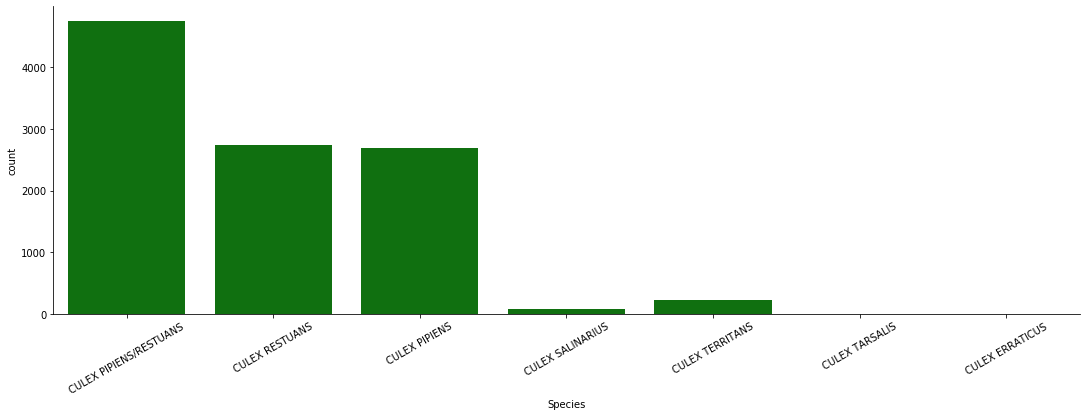

In [14]:
# Species Data for train dataset
g = sns.factorplot("Species", data=train, aspect=3,
                       kind="count", color='green')
g.set_xticklabels(rotation=30)

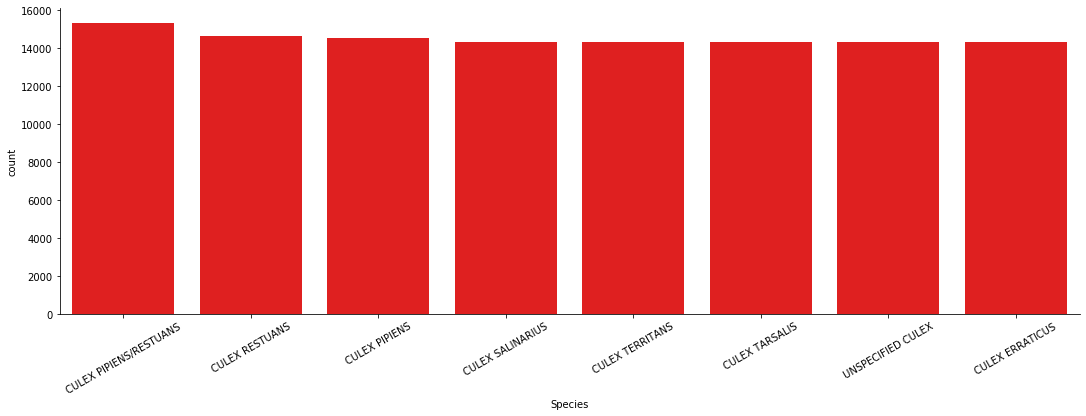

In [15]:
# Species Data for test dataset
g = sns.factorplot("Species", data=test, aspect=3,
                       kind="count", color='red')
g.set_xticklabels(rotation=30)

The test dataset has an additional column for Unspecified Culex Species and the distriution of the records in test set is evenly spead across the different species. Fot the train set, the records are skewed towards the CULEX PIPENS/RESTUANS species. For future datasets it will be ideal to get a train and test datasets that are evenly distributed.

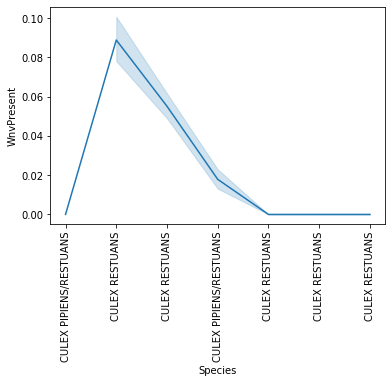

In [16]:
g = sns.lineplot(train.Species,train.WnvPresent)
g.set_xticklabels(train.Species,rotation=90);

In [17]:
# Creation of dummy columns for the species
train_test['Species'] = train_test['Species'].str.lower()
train_test['Species']  = train_test['Species'].str.replace(' ', '_')
train_test = pd.concat([train_test, pd.get_dummies(train_test.Species)], axis=1)
train_test.drop(['Species'],axis =1, inplace =True)

 We are left with the Date column to investigate.

In [18]:
# As the test and train set are from completely different year we shall not take the year into considerations, if we take 
# the days and hot encode it, it will result in 365 columns which is not sensible. Therefore using the month was decided as
# the approach
date = train_test.Date.str.split('-')
date = pd.DataFrame([item for item in date] ,columns = ["Year", "Month", "Day"])
train_test['Month'] = date.Month
train_test['Year'] = date.Year

In [19]:
# Creation of dummy columns for the Month
train_test.Month = train_test.Month.replace({'05':'may','06':'jun','07':'jul','08':'aug','09':'sep','10':'oct','11':'nov','12':'dec'})
pd.concat([train_test, pd.get_dummies(train_test['Month'])],axis =1)
train_test.drop(['Month'],axis =1,inplace=True)

C:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


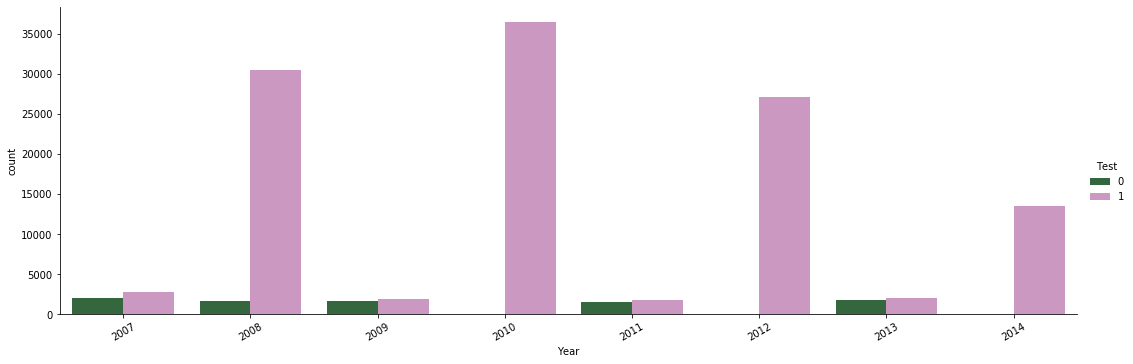

In [20]:
# The dates for train set are from not available for 2010,2012 and 2014
train_test['Test'] = train_test.Id.notnull().astype(int)
g = sns.factorplot("Year", data=train_test, aspect=3,
                       kind="count", palette='cubehelix',hue = 'Test')
g.set_xticklabels(rotation=30)

# The test_column was created just for distinguishing train and test above and thus shall be dropped. Furthermore the year
# column shall also be dropped as it is not available for all Years for the training Data 
train_test.drop(['Test','Year'],axis = 1,inplace = True)

In [21]:
# Separation to cleaned train and test sets
train_clean = train_test[train_test.Id.isnull()]
test_clean = train_test[train_test.Id.notnull()]

In [22]:
# Removing the Id column from train set as it is only meant for kaggle submission in the test set
train_clean.drop(['Id'],axis =1 ,inplace=True)
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 10505
Columns: 147 entries, Date to unspecified_culex
dtypes: float64(3), object(1), uint8(143)
memory usage: 1.5+ MB


C:\Anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
# Removing the target variable WnvPresent from the test dataset
test_clean.drop(['WnvPresent'],axis =1 ,inplace=True)
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Columns: 147 entries, Date to unspecified_culex
dtypes: float64(3), object(1), uint8(143)
memory usage: 20.3+ MB


### Joining together with the cleaned weather data

In [24]:
weather_clean = pd.read_csv('../data/weather_clean.csv')
weather_clean.rename(columns = {'date':'Date'},inplace = True)

In [25]:
train_clean = train_clean.merge(weather_clean,how='inner',on='Date')
test_clean = test_clean.merge(weather_clean,how='inner',on='Date')
train_clean.drop(['Date'],axis=1,inplace =True)
test_clean.drop(['Date'],axis=1,inplace =True)

In [26]:
train_clean.to_csv('../data/train_clean.csv',index = False)
test_clean.to_csv('../data/test_clean.csv',index = False)